# Deep Learning Toolkit for Splunk - Causalnex

This notebook contains a barebone example workflow how to work on custom containerized code that seamlessly interfaces with the Deep Learning Toolkit for Splunk.

Note: By default every time you save this notebook the cells are exported into a python module which is then invoked by Splunk MLTK commands like <code> | fit ... | apply ... | summary </code>. Please read the Model Development Guide in the Deep Learning Toolkit app for more information.

## Stage 0 - import libraries
At stage 0 we define all imports necessary to run our subsequent code depending on various libraries.

In [18]:
# this definition exposes all python module imports that should be available in all subsequent commands
import json
import numpy as np
import pandas as pd
from causalnex.structure import DAGRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
# ...
# global constants
MODEL_DIRECTORY = "/srv/app/model/data/"

In [19]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print("numpy version: " + np.__version__)
print("pandas version: " + pd.__version__)

numpy version: 1.18.1
pandas version: 0.25.3


## Stage 1 - get a data sample from Splunk
In Splunk run a search to pipe a dataset into your notebook environment. Note: mode=stage is used in the | fit command to do this.

| makeresults count=10<br>
| streamstats c as i<br>
| eval s = i%3<br>
| eval feature_{s}=0<br>
| foreach feature_* [eval &lt;&lt;FIELD&gt;&gt;=random()/pow(2,31)]<br>
| fit MLTKContainer mode=stage algo=barebone epochs=10 batch_size=1 s from feature_* into app:barebone_model

After you run this search your data set sample is available as a csv inside the container to develop your model. The name is taken from the into keyword ("barebone_model" in the example above) or set to "default" if no into keyword is present. This step is intended to work with a subset of your data to create your custom model.

In [22]:
# this cell is not executed from MLTK and should only be used for staging data into the notebook environment
def stage(name):
    with open("data/"+name+".csv", 'r') as f:
        df = pd.read_csv(f)
    with open("data/"+name+".json", 'r') as f:
        param = json.load(f)
    return df, param

In [23]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
df, param = stage("causalnex")
print(df.describe())
print(df.head())

       median_house_value  crime_rate   land_zone  business_acres  \
count          506.000000  506.000000  506.000000      506.000000   
mean            22.532806    3.613524   11.363636       11.136779   
std              9.197104    8.601545   23.322453        6.860353   
min              5.000000    0.006320    0.000000        0.460000   
25%             17.025000    0.082045    0.000000        5.190000   
50%             21.200000    0.256510    0.000000        9.690000   
75%             25.000000    3.677082   12.500000       18.100000   
max             50.000000   88.976200  100.000000       27.740000   

       charles_river_adjacency  nitric_oxide_concentration  \
count               506.000000                  506.000000   
mean                  0.069170                    0.554695   
std                   0.253994                    0.115878   
min                   0.000000                    0.385000   
25%                   0.000000                    0.449000   
50%   

## Stage 2 - create and initialize a model

In [24]:
# initialize your model
# available inputs: data and parameters
# returns the model object which will be used as a reference to call fit, apply and summary subsequently
def init(df,param):
    model = DAGRegressor(
                alpha=0.1,
                beta=0.9,
                fit_intercept=True,
                hidden_layer_units=None,
                dependent_target=True,
                enforce_dag=True,
                 )
    return model

In [25]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
model = init(df,param)
print(init(df,param))

DAGRegressor(alpha=0.1, beta=0.9, dependent_target=True, dist_type_schema=None,
             enforce_dag=True, fit_intercept=True, hidden_layer_units=None,
             standardize=False, tabu_child_nodes=None, tabu_edges=None,
             tabu_parent_nodes=None, threshold=0.0)


## Stage 3 - fit the model

In [26]:
# train your model
# returns a fit info json object and may modify the model object
def fit(model,df,param):
    
    target=param['target_variables'][0]
    
    #Data prep for processing
    y_p = df[target]
    y = y_p.values

    X_p = df[param['feature_variables']]
    X = X_p.to_numpy()
    X_col = list(X_p.columns)

    #Scale the data
    ss = StandardScaler()
    X_ss = ss.fit_transform(X)
    y_ss = (y - y.mean()) / y.std()
    
    scores = cross_val_score(model, X_ss, y_ss, cv=KFold(shuffle=True, random_state=42))
    print(f'MEAN R2: {np.mean(scores).mean():.3f}')

    X_pd = pd.DataFrame(X_ss, columns=X_col)
    y_pd = pd.Series(y_ss, name=target)

    model.fit(X_pd, y_pd)
    
    info = pd.Series(model.coef_, index=X_col)
    #info = pd.Series(model.coef_, index=list(df.drop(['_time'],axis=1).columns))
    return info

In [27]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(param['target_variables'][0])
print(fit(model,df,param))

median_house_value
MEAN R2: 0.643
crime_rate                       0.00000
land_zone                        0.00000
business_acres                   0.00000
charles_river_adjacency          0.00000
nitric_oxide_concentration       0.00000
avg_rooms_per_dwelling           0.45491
units_prior_1940                 0.00000
distance_to_employment_center    0.00000
highway_accessibility_index      0.00000
property_tax_rate                0.00000
pupil_teacher_ratio              0.00000
dtype: float64


## Stage 4 - apply the model

In [28]:
# apply your model
# returns the calculated results
def apply(model,df,param):
    data = []

    for col in list(df.columns):
        s = model.get_edges_to_node(col)
        for i in s.index:
            data.append([i,col,s[i]]);

    graph = pd.DataFrame(data, columns=['src','dest','weight'])

    #results to send back to Splunk
    graph_output=graph[graph['weight']>0]
    return graph_output

                               src                           dest    weight
5           avg_rooms_per_dwelling             median_house_value  0.454910
19     highway_accessibility_index                     crime_rate  0.427227
29   distance_to_employment_center                      land_zone  0.464600
42               property_tax_rate                 business_acres  0.361330
57                  business_acres     nitric_oxide_concentration  0.389692
81      nitric_oxide_concentration               units_prior_1940  0.515855
94                units_prior_1940  distance_to_employment_center  0.457677
108              property_tax_rate    highway_accessibility_index  0.774805
122                      land_zone            pupil_teacher_ratio  0.295381
125     nitric_oxide_concentration            pupil_teacher_ratio  0.304463
129    highway_accessibility_index            pupil_teacher_ratio  0.289137


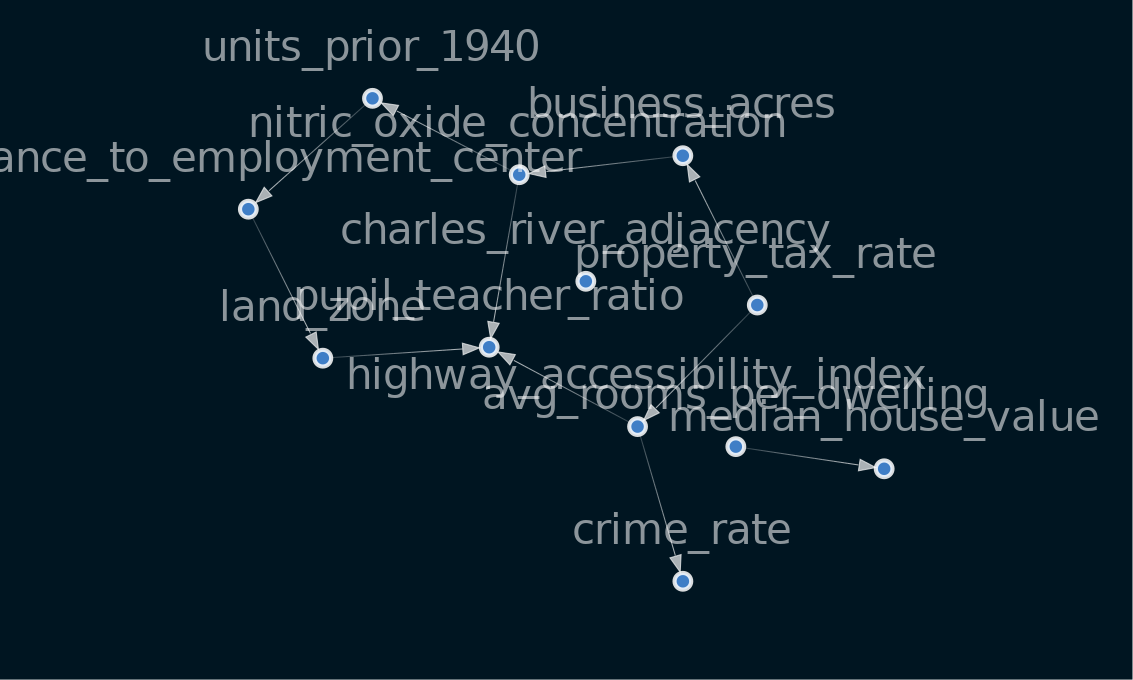

In [29]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(apply(model,df,param))

model.plot_dag(True)

## Stage 5 - save the model

In [ ]:
# save model to name in expected convention "<algo_name>_<model_name>"
def save(model,name):
    #with open(MODEL_DIRECTORY + name + ".json", 'w') as file:
    #    json.dump(model, file)
    return model

## Stage 6 - load the model

In [ ]:
# load model from name in expected convention "<algo_name>_<model_name>"
def load(name):
    model = {}
    #with open(MODEL_DIRECTORY + name + ".json", 'r') as file:
    #    model = json.load(file)
    return model

## Stage 7 - provide a summary of the model

In [ ]:
# return a model summary
def summary(model=None):
    returns = {"version": {"numpy": np.__version__, "pandas": pd.__version__} }
    return returns

After implementing your fit, apply, save and load you can train your model:<br>
| makeresults count=10<br>
| streamstats c as i<br>
| eval s = i%3<br>
| eval feature_{s}=0<br>
| foreach feature_* [eval &lt;&lt;FIELD&gt;&gt;=random()/pow(2,31)]<br>
| fit MLTKContainer algo=barebone s from feature_* into app:barebone_model<br>

Or apply your model:<br>
| makeresults count=10<br>
| streamstats c as i<br>
| eval s = i%3<br>
| eval feature_{s}=0<br>
| foreach feature_* [eval &lt;&lt;FIELD&gt;&gt;=random()/pow(2,31)]<br>
| apply barebone_model as the_meaning_of_life

## End of Stages
All subsequent cells are not tagged and can be used for further freeform code